In [2]:
import pandas as pd
MasterFile=pd.read_csv('../dataset/faces/FaceScore.csv')  # 读取数据文件
print(MasterFile.shape)
MasterFile[0:5] # 查看数据文件

(5500, 2)


,Filename,Rating
0,ftw1.jpg,4.083333
1,ftw10.jpg,3.666667
2,ftw100.jpg,1.916667
3,ftw101.jpg,2.416667
4,ftw102.jpg,3.166667


在本周的课程中，我们学习了基于PyTorch的神经网络模型的搭建与训练。第三次作业的内容就是巩固课堂所学的相关知识，使用课堂案例颜值打分数据完成作业。具体要求如下：

【1】内容包含齐全，仿照课程代码，至少包含：数据读取、可视化、生成数据生成器、模型的建立、模型的总结、模型的训练、模型的预测；

【2】模型要求：线性回归模型或多层神经网络（更复杂的模型不要考虑），请使用文字说明模型参数量是怎么算出来的；

【3】代码要求：逐行注释（为了让大家理解神经网络的编程逻辑）；

【4】其他设置可以自行探索，例如：图像尺寸、优化器选择、学习率、迭代epoch数目等；

【5】成绩构成：代码和内容完整性占80%，验证集MSE结果占20%（请统一设定训练集和验证集比例为7:3，若训练集高于70%得到更好的结果也不会加分）。

【6】请根据模板完成，最终提交pdf文件（将ipynb文件保存为html，然后html通过打印可以保存为pdf）。

array([[<AxesSubplot:title={'center':'Rating'}>]], dtype=object)

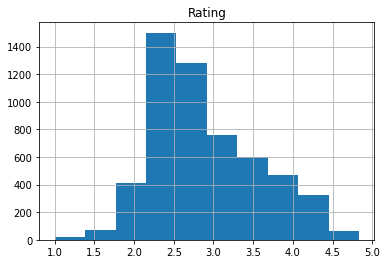

In [3]:
import matplotlib.pylab as plt
MasterFile.hist() # 绘制直方图

In [7]:
# 构建Dataset类
from PIL import Image
import numpy as np
from itertools import islice

def default_loader(path):
    return Image.open(path) #根据图片路径读取图片

class Dataset():
    def __init__(self, loader=default_loader, transform=None):
        with open('../dataset/faces/FaceScore.csv', 'r') as f:   # 以只读的方式打开文件
            imgs = []                                            # 创建空列表存储图片路径以及打分数据
            for line in islice(f, 1, None): # 对f进行切片迭代，从第1行开始读取，即跳过csv文件首行的标题
                line = line.strip('\n') # 去除末尾换行符
                line = line.split(',') # 将一行拆分成图片名称和颜值打分数
                im = '../dataset/faces/images/' + line[0] # 图片路径
                imgs.append((im, float(line[1])))    # 添加图片路径与得分组成的元组
        self.imgs = imgs    # 将imgs赋给实例属性imgs
        self.loader = loader  # 将loader赋给实例属性loader
        self.transform = transform  # 将transform赋给实例属性transform
        
    def __len__(self):     # 定义私有方法len，返回imgs列表的元素个数
        return len(self.imgs)
    
    def __getitem__(self, index):   # 定义私有方法getitem，即如何按照index进行存取元素
        images, labels = self.imgs[index]  # 取出imgs的路径与得分
        img = self.loader(images)   # 将路径传给loader方法以获取图片信息
        img = self.transform(img)   # 再将图片信息传给transform
        return img, labels  #返回图片信息与得分数据

from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)), # 变形为网络所需的输入形状（ 128 * 128）
    transforms.ToTensor(), # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

# 根据Dataset长度设置训练集和验证集的划分长度
full_data = Dataset(transform=transform)  # 创建Dataset类
train_size = int(len(full_data) * 0.7)  # 这里train_size是一个长度矢量，并非是比例，我们将训练和测试进行7/3划分
val_size = len(full_data) - train_size   # 剩下的为测试集数据的size
 
# 从Dataset随机划分训练集和验证集 
train_set, val_set = random_split(full_data, [train_size, val_size])   

In [8]:
# 构建数据读取器
import torch
batch_size = 64   # 设置一次训练的数据量为64
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size, shuffle=True, num_workers=4)  # 读入训练集，设置batch_size为64，且将训练集打乱，定义多线程处理
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([64, 3, 128, 128])
torch.Size([64])


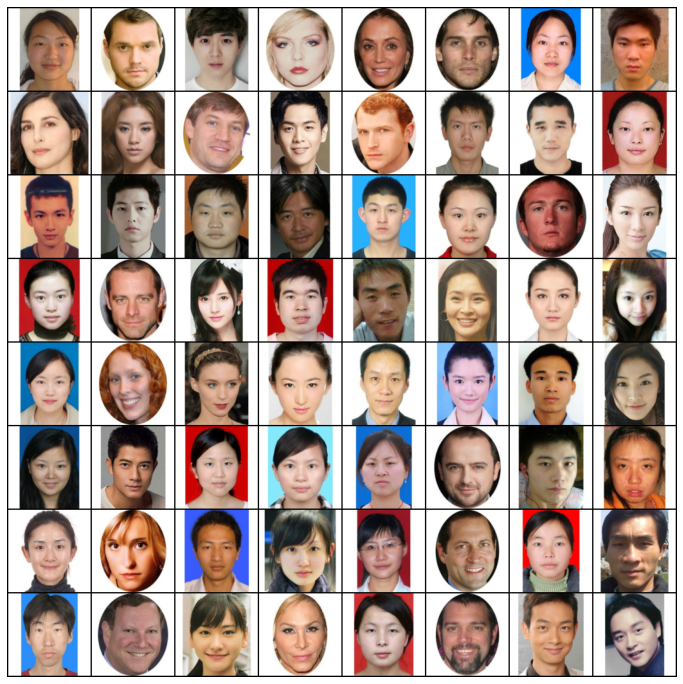

In [9]:
# 展示训练集中第一个批次的图像
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 将train_loader装换成可迭代对象，使用next获取训练集第一个批次中的图片及相应标签
print(images.shape)   # 输出一个batch的图片的shape    64*3*128*128
print(labels.shape)   # 输出标签的shape     64
plt.figure(figsize=(12, 20))  # 设置画布大小，类似于放大
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，一行为8张图片，permute函数调换channel维的顺序
plt.show()

In [10]:
# 构建线性回归模型
import torch
import torch.nn as nn
from torchsummary import summary

class LinearRegression(torch.nn.Module):   # 创建线性回归类，torch.nn.Module是神经网络模块的基类
    def __init__(self):
        super(LinearRegression,self).__init__()   # 继承父类的构造方法
        self.layer1 = torch.nn.Linear(128 * 128 * 3, 1)   # 设置属性layer1为：输入维度为128*128*3，输出为一维
    def forward(self, x):    # 定义类方法
        x = x.reshape(-1, 128 * 128 * 3) # 将输入拉直成128*128*3的向量，其中-1代表根据已经确定的128*128*3维度，自动计算x第一个shape属性。
        x = self.layer1(x)    # 将x输入线性模型，结果为一维数据
        return x
    
# 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 128
linearregression_model = LinearRegression().cuda()   # 把模型放在cuda上运行
# summary的第一个从参数为模型，第二个参数为输入的尺寸（3维立体矩阵）
summary(linearregression_model, (3, IMSIZE, IMSIZE))     # 输出为1维，共训练参数3*128*128+1=49153

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]          49,153
Total params: 49,153
Trainable params: 49,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


In [12]:
# 模型训练
device = "cuda" #指定设备为gpu
def mse_metric(outputs, labels):
    return torch.sum(pow((outputs.view(-1) - labels), 2)) / len(outputs.view(-1)) # 计算均方误差

# 模型验证
def validate(model, val_loader):
    val_loss = 0   # 初始化loss
    val_mse = 0    # 初始化mse
    model.eval()    # 将模型中的某些特定层或部分切换到评估模式
    for inputs, labels in val_loader:    # 在测试集上验算
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = torch.nn.MSELoss()(outputs.view(-1), labels.to(torch.float32))  # 计算均方误差损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        mse = mse_metric(outputs, labels)  # 计算均方误差
        val_mse += mse
    val_loss /= len(val_loader)  # 计算平均损失
    val_mse /= len(val_loader)  # 计算平均均方误差
    return val_loss, val_mse

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_mse, val_loss, val_mse, epochs=10):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, mse: {train_mse:.4f}, val_loss: {val_loss:.4f}, val_mse: {val_mse:.4f}")

import time
# 定义主函数：模型训练
def train(model, optimizer, train_loader, val_loader, epochs=1):
    train_losses = []; train_mses = [];
    val_losses = []; val_mses = [];
    model.train()    # 进入训练模式
    for epoch in range(epochs):
        train_loss = 0   # 初始化训练损失
        train_mse = 0    # 初始化训练的mse
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = torch.nn.MSELoss()(outputs.view(-1), labels.to(torch.float32))  # 计算损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            mse = mse_metric(outputs, labels)  # 计算均方误差
            train_mse += mse
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
            
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时 
        train_loss /= len(train_loader)  # 计算平均损失
        train_mse /= len(train_loader)  # 计算平均均方误差
        val_loss, val_mse = validate(model, val_loader)  # 计算测试集上的损失函数和准确
        train_losses.append(train_loss); train_mses.append(train_mse)   # 添加训练集上的loss与mse
        val_losses.append(val_loss); val_mses.append(val_mse)   # 添加测试集上的loss与mse
        print_log(epoch + 1, train_time, train_loss, train_mse, val_loss, val_mse, epochs=epochs)  # 打印训练结果
    return train_losses, train_mses, val_losses, val_mses

lr = 1e-5  # 设置初始学习率
epochs = 10
optimizer = torch.optim.Adam(linearregression_model.parameters(), lr=lr)  # 设置优化器
history = train(linearregression_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/10], time: 7.74s, loss: 0.2981, mse: 0.2981, val_loss: 0.3099, val_mse: 0.3099
Epoch [2/10], time: 7.43s, loss: 0.2742, mse: 0.2742, val_loss: 0.3134, val_mse: 0.3134
Epoch [3/10], time: 7.96s, loss: 0.2780, mse: 0.2780, val_loss: 0.3103, val_mse: 0.3103
Epoch [4/10], time: 8.72s, loss: 0.2736, mse: 0.2736, val_loss: 0.3090, val_mse: 0.3090
Epoch [5/10], time: 7.74s, loss: 0.2706, mse: 0.2706, val_loss: 0.3090, val_mse: 0.3090
Epoch [6/10], time: 7.31s, loss: 0.2713, mse: 0.2713, val_loss: 0.3192, val_mse: 0.3192
Epoch [7/10], time: 7.89s, loss: 0.2691, mse: 0.2691, val_loss: 0.3090, val_mse: 0.3090
Epoch [8/10], time: 7.30s, loss: 0.2731, mse: 0.2731, val_loss: 0.3086, val_mse: 0.3086
Epoch [9/10], time: 7.56s, loss: 0.2708, mse: 0.2708, val_loss: 0.3189, val_mse: 0.3189
Epoch [10/10], time: 7.45s, loss: 0.2739, mse: 0.2739, val_loss: 0.3107, val_mse: 0.3107


神经网络猜测图片颜值打分是 1.6223375797271729, 实际得分是 2.3333333333333335


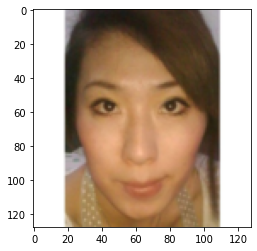

In [13]:
# 模型预测
# 挑选valloader中的一张图片作为测试
dataiter = iter(val_loader)    # 将val_loader转换为可迭代对象
images, labels = dataiter.next()   # 取第一个batch的images与labels
img = images[3].permute((1, 2, 0))    # 将第4张images的颜色通道换顺序
lbl = labels[3]   # 取第三张图片的得分
plt.imshow(img)
# 将测试图片转为一维的列向量
img = torch.from_numpy(img.numpy())
img = img.reshape(1, 128 * 128 * 3)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = linearregression_model.forward(img.to(device))
    
prediction = float(output)
print(f'神经网络猜测图片颜值打分是 {prediction}, 实际得分是 {lbl}')